In [1]:
# Подключение библиотек

import sys
!{sys.executable} -m pip install --user numpy
!{sys.executable} -m pip install --user seaborn
!{sys.executable} -m pip install --user pandas
!{sys.executable} -m pip install --user dataclass-csv
!{sys.executable} -m pip install --user networkx
!{sys.executable} -m pip install --user simple-term-menu

import csv
import itertools
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx

from enum import Enum
from typing import Optional
from dataclasses import dataclass
from dataclass_csv import DataclassReader

In [2]:
# Вспомогательные структуры даных

@dataclass
class DatasetItem:
    name: str
    full_name: str
    width: int
    height: int
    death: int
    sale_price: int
    country: str = ""
    style: str = ""   # 
    subject: str = "" # 
    genre: str = ""   # 
    medium: str = ""  # 
    exhibition: bool = False
    for_sale: bool = False
    restored: bool = False

class PriceMeasure(Enum):
    VeryHighPrice = 1
    HighPrice    = 2
    OptimalPrice  = 3
    LowPrice      = 4
    TooLowPrice   = 5

@dataclass
class Filter:
    """
    Структура ограничений на поиск
    """
    name:           Optional[str] = None
    full_name:      Optional[str] = None
    width_min:      Optional[int] = None
    width_max:      Optional[int] = None
    height_min:     Optional[int] = None
    height_max:     Optional[int] = None
    sale_price_min: Optional[int] = None
    sale_price_max: Optional[int] = None
    century_min:    Optional[int] = None
    century_max:    Optional[int] = None
    country:        Optional[str] = None
    style:      Optional[str]  = None
    subject:    Optional[str]  = None
    genre:      Optional[str]  = None
    medium:     Optional[str]  = None
    exhibition: Optional[bool] = None
    for_sale:   Optional[bool] = None
    restored:   Optional[bool] = None

    price_approx: Optional[PriceMeasure] = None

    limit:      Optional[int]  = None

In [3]:
# Вспомогательные функции для расчета значений мер

# Центральый момент
def get_distance(v1, v2, nPow) -> float:
    res = 0.0
    for i in range(len(v1)):
        if v1[i] == None or v2[i] == None:
            continue
        res += pow(abs(v1[i] - v2[i]), nPow)
    return pow(res, 1.0 / nPow)

# Манхэттенское расстояние
def get_manhattan_distance(v1, v2) -> float:
    return get_distance(v1, v2, 1)

# Евклидово расстояние
def get_euclidean_distance(v1, v2) -> float:
    return get_distance(v1, v2, 2)

# Нормализация дипазона
def normalize(field: int, min_field: int, max_field: int) -> float:
    if max_field == min_field:
        return 0.0
    return (field - min_field) / (max_field - min_field)

# Обратная мера
def reverse_measure(field1: int, field2: int, min_field: int, max_field: int) -> float:
    if field1 == field2:
        return 0.0
    return 1.0 / (abs(normalize(field1, min_field, max_field) - normalize(field2, min_field, max_field)))

# Косинусная мера
def cos_measure(v1, v2) -> float:
    v1T, v2T = v1.copy(), v2.copy()
    n = len(v1)
    indArr = [i for i, (elem1, elem2) in enumerate(zip(v1T, v2T)) if isnan(elem1) or isnan(elem2)]
    v1T[:] = [elem for i, elem in enumerate(v1T) if i not in indArr]
    v2T[:] = [elem for i, elem in enumerate(v2T) if i not in indArr]
    return 1.0 - dot(v1T, v2T) / (norm(v1T) * norm(v2T))

# Мера Жаккара
def get_jaccard(v1: list[bool], v2: list[bool]) -> float:
    a = v1.count(1)
    b = v2.count(1)
    c = 0.0
    if a == 0 and b == 0:
        return 0.0
    for i in range(len(v1)):
        if v1[i] and v2[i]:
            c += 1
    return 1.0 - c / (a + b - c)

In [4]:
# Вспомогательные функции для расчета значений мер в домене

G = nx.Graph()

G.add_edge("ROOT", "Portrait", weight=0.0)
G.add_edge("ROOT", "Scenery", weight=0.0)
G.add_edge("ROOT", "Still-life", weight=0.0)

G.add_edge("Portrait", "Self-portrait", weight=1.0)
G.add_edge("Portrait", "Historical portrait", weight=1.0)
G.add_edge("Portrait", "Posthumous portrait", weight=1.0)
G.add_edge("Portrait", "Religious portrait", weight=1.0)

G.add_edge("Scenery", "Marinus", weight=1.0)
G.add_edge("Scenery", "Industrial", weight=1.0)
G.add_edge("Scenery", "Historical", weight=1.0)
G.add_edge("Scenery", "Fantasy", weight=1.0)
G.add_edge("Scenery", "Landscape", weight=1.0)

G.add_edge("Still-life", "Floral-fruity", weight=1.0)
G.add_edge("Still-life", "Kitchen", weight=1.0)
G.add_edge("Still-life", "Vanitas", weight=1.0)

G.add_edge("Self-portrait", "Insertable", weight=2.0)
G.add_edge("Self-portrait", "Executive", weight=2.0)
G.add_edge("Self-portrait", "Group portrait", weight=2.0)
G.add_edge("Self-portrait", "Separate", weight=2.0)

G.add_edge("Historical portrait", "Historical Events", weight=2.0)
G.add_edge("Historical portrait", "Historical characters", weight=2.0)

G.add_edge("Religious portrait", "Religious Events", weight=2.0)
G.add_edge("Religious portrait", "Religious characters", weight=2.0)

G.add_edge("Marinus", "Open sea", weight=2.0)
G.add_edge("Marinus", "Coast", weight=2.0)
G.add_edge("Marinus", "Rivers/Lakes", weight=2.0)

G.add_edge("Industrial", "Bridges", weight=2.0)
G.add_edge("Industrial", "Residential buildings", weight=2.0)
G.add_edge("Industrial", "Industrial building", weight=2.0)
G.add_edge("Industrial", "Sights", weight=2.0)

G.add_edge("Floral-fruity", "Floral predominate", weight=2.0)
G.add_edge("Floral-fruity", "Fruits predominate", weight=2.0)

G.add_edge("Vanitas", "Steel arms", weight=2.0)
G.add_edge("Vanitas", "Human scull", weight=2.0)
G.add_edge("Vanitas", "Clocks", weight=2.0)
G.add_edge("Vanitas", "Table games", weight=2.0)

def get_genre_distance(item1, item2) -> float:
    return nx.shortest_path_length(G, source=item1.genre, target=item2.genre) 

country_dict = {"USA": 0, "Russia": 1, "United Kingdom": 2, "Spain": 3, "France": 4}

country_matr = [
    [0.0, 1.0, 0.5, 0.6, 0.6],
    [1.0, 0.0, 0.4, 0.4, 0.4],
    [0.5, 0.4, 0.0, 0.2, 0.2],
    [0.6, 0.4, 0.2, 0.0, 0.1],
    [0.6, 0.4, 0.2, 0.1, 0.0],
]

# Сравнение стран
def get_country_distance(item1, item2) -> float:
    if item1.country == '' or item2.country == '':
        return 1.0
    if (not item1.country in country_dict) or (not item2.country in country_dict):
        return 1.0
    return country_matr[country_dict[item1.country]][country_dict[item2.country]]

subject_dict = {"Portraits": 0, "Still-Life": 1,
               "Nude": 2, "Abstract/Modern Art": 3,
               "Marine Art/Maritime": 4, "Landscape Art": 5,
               "Rivers/Lakes": 6, "Gardens": 7 }

subject_matr = [
    [0.0, 0.9, 0.2, 0.8, 1.0, 1.0, 1.0, 1.0],
    [0.9, 0.0, 0.9, 1.0, 1.0, 0.8, 0.8, 0.8],
    [0.2, 0.9, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [0.8, 1.4, 1.2, 0.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 0.0, 0.7, 0.2, 0.9],
    [1.0, 0.8, 1.0, 1.0, 0.7, 0.0, 0.6, 0.5],
    [1.0, 0.8, 1.0, 1.0, 0.2, 0.6, 0.0, 0.9],
    [1.0, 0.8, 1.0, 1.0, 0.9, 0.5, 0.9, 0.0],
]

# Сравнение стран
def get_subject_distance(item1, item2) -> float:
    if item1.subject == '' or item2.subject == '':
        return 1.0
    if (not item1.subject in subject_dict) or (not item2.subject in subject_dict):
        return 1.0
    return subject_matr[subject_dict[item1.subject]][subject_dict[item2.subject]]

style_dict = {"Impressionism": 0, "Post-Impressionism": 1,
             "Baroque": 2, "Cubism": 3,
             "Renaissance": 4, "Rococo": 5,
             "Classicism": 6, "American Landscape": 7,
             "Expressionism": 8, "Romanticism": 9,
             "Art Nouveau": 10, "Realism": 11 }

style_matr = [
    [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
]

# Сравнение стран
def get_style_distance(item1, item2) -> float:
    if item1.style == '' or item2.style == '':
        return 1.0
    if (not item1.style in style_dict) or (not item2.style in style_dict):
        return 1.0
    return style_matr[style_dict[item1.style]][style_dict[item2.style]]

medium_dict = {"Oil on canvas": 0, "Pencil": 1,
              "Watercolor": 2, "Drybrush": 3}

medium_matr = [
    [0.0, 0.9, 0.8, 1.0],
    [0.9, 0.0, 1.0, 0.3],
    [0.8, 1.0, 0.0, 1.0],
    [1.0, 0.4, 1.0, 0.0],
]

# Сравнение стран
def get_medium_distance(item1, item2) -> float:
    if item1.medium == '' or item2.medium == '':
        return 1.0
    if (not item1.medium in medium_dict) or (not item2.medium in medium_dict):
        return 1.0
    return medium_matr[medium_dict[item1.medium]][medium_dict[item2.medium]]


def items_get_jaccard(item1, item2) -> float:
    fields1 = [item1.exhibition, item1.for_sale, item1.restored]
    fields2 = [item2.exhibition, item2.for_sale, item2.restored]
    return get_jaccard(fields1, fields2)


def items_get_size_distance(item1, item2) -> float:
    fields1 = [item1.width, item1.height]
    fields2 = [item2.width, item2.height]
    return get_euclidean_distance(fields1, fields2)


def get_century_from_death(death: int):
    return death // 100


def items_get_century_distance(item1, item2) -> float:
    fields1 = [get_century_from_death(item1.death)]
    fields2 = [get_century_from_death(item2.death)]
    return get_euclidean_distance(fields1, fields2)


def items_get_price_distance(item1, item2) -> float:
    fields1 = [item1.sale_price]
    fields2 = [item2.sale_price]
    return get_euclidean_distance(fields1, fields2)


def get_measure_for_price(price: int) -> PriceMeasure:
    if price > 750:
        return PriceMeasure.VeryHighPrice
    elif price > 650:
        return PriceMeasure.HighPrice
    elif price > 550:
        return PriceMeasure.OptimalPrice
    elif price > 450:
        return PriceMeasure.LowPrice
    else:
        return PriceMeasure.TooLowPrice

In [5]:
# Основные функции расчета мер

# TODO: подумать, насколько разряженными могут быть матрицы значений мер. Да и в общем, как часто ее расчитывают. 
# Могут ли ее расчитывать только для отдельных элементов?
# Могут ли ее расчитывать для всего набора данных?
# Тут и вылезают эффективные алгоритмы перемножения матриц, структуры для их хранения и т.д

@dataclass
class Ranger:
    """
    Структура ограничений на поиск
    """
    width_min:      int = 0
    width_max:      int = 0
    height_min:     int = 0
    height_max:     int = 0
    sale_price_min: int = 0
    sale_price_max: int = 0
    century_min:    int = 0
    century_max:    int = 0

def calc_ranger(items: list[DatasetItem]) -> Ranger:
    ranger = Ranger()
    if len(items) == 0:
        return ranger
    ranger.width_min = items[0].width
    ranger.width_max = items[0].width
    ranger.height_min = items[0].height
    ranger.height_max = items[0].width
    ranger.sale_price_min = items[0].sale_price
    ranger.sale_price_max = items[0].sale_price
    ranger.century_min = get_century_from_death(items[0].death)
    ranger.century_max = get_century_from_death(items[0].death)
    for item in items:
        ranger.width_min = min(item.width, ranger.width_min)
        ranger.width_max = max(item.width, ranger.width_max)
        ranger.height_min = min(item.height, ranger.height_min)
        ranger.height_max = max(item.height, ranger.height_max)
        ranger.sale_price_min = min(item.sale_price, ranger.sale_price_min)
        ranger.sale_price_max = max(item.sale_price, ranger.sale_price_max)
        ranger.century_min = min(get_century_from_death(item.death), ranger.century_min)
        ranger.century_max = max(get_century_from_death(item.death), ranger.century_max)
    return ranger

# Сделать работу с матрицами: это немного увеличит пиковое потребление памяти,
# но позволит быстрее вычислить произведение,
# "проще" получить min/max для нормализации значений
def calc_measure_main(item1, item2, min_values: Ranger):
    size_dist = items_get_size_distance(item1, item2) / 35
    century_dist = items_get_century_distance(item1, item2) / 4
    price_dist = items_get_price_distance(item1, item2) / 500

    country_dist = get_country_distance(item1, item2)
    style_dist = get_style_distance(item1, item2)
    subject_dist = get_subject_distance(item1, item2)
    medium_dist = get_medium_distance(item1, item2)

    genre_dist = get_genre_distance(item1, item2) / 8

    jaccard_dist = items_get_jaccard(item1, item2) / 3

    k_size, k_century, k_price = 0.1, 0.3, 0.5
    k_country, k_style, k_subject, k_medium = 0.2, 0.7, 0.8, 0.7
    k_genre = 0.8
    k_jaccard = 0.05

    return (k_size * size_dist + k_century * century_dist + k_price * price_dist \
            + k_country * country_dist + k_style * style_dist + k_subject * subject_dist \
            + k_medium * medium_dist + k_genre * genre_dist + k_jaccard * jaccard_dist)

def calc_measure_money(item1, item2, min_values: Ranger):
    size_dist = items_get_size_distance(item1, item2) / 35
    century_dist = items_get_century_distance(item1, item2) / 4
    price_dist = items_get_price_distance(item1, item2) / 500

    country_dist = get_country_distance(item1, item2)
    style_dist = get_style_distance(item1, item2)
    subject_dist = get_subject_distance(item1, item2)
    medium_dist = get_medium_distance(item1, item2)

    genre_dist = get_genre_distance(item1, item2) / 8

    jaccard_dist = items_get_jaccard(item1, item2) / 3

    k_size, k_century, k_price = 0.1, 0.1, 1.5
    k_country, k_style, k_subject, k_medium = 0.1, 0.1, 0.1, 0.1
    k_genre = 0.1
    k_jaccard = 0.1

    return (k_size * size_dist + k_century * century_dist + k_price * price_dist \
            + k_country * country_dist + k_style * style_dist + k_subject * subject_dist \
            + k_medium * medium_dist + k_genre * genre_dist + k_jaccard * jaccard_dist)

In [6]:
# Вспомогательные функции API

def filter_min(items: list, get_value_lambda, min_value: Optional) -> list:
    return filter(lambda item: True if (min_value is None) or (get_value_lambda(item) >= min_value) else False, items)

def filter_max(items: list, get_value_lambda, max_value: Optional) -> list:
    return filter(lambda item: True if (max_value is None) or (get_value_lambda(item) <= max_value) else False, items)

def filter_eq(items: list, get_value_lambda, exact_value: Optional) -> list:
    return filter(lambda item: True if (exact_value is None) or (get_value_lambda(item) == exact_value) else False, items)

def filter_items(items: list[DatasetItem], filter: Filter) -> list[DatasetItem]:
    items = filter_min(items, lambda item: item.width, filter.width_min)
    items = filter_max(items, lambda item: item.width, filter.width_max)
    items = filter_min(items, lambda item: item.height, filter.height_min)
    items = filter_max(items, lambda item: item.height, filter.height_max)
    items = filter_min(items, lambda item: get_century_from_death(item.death), filter.century_min)
    items = filter_max(items, lambda item: get_century_from_death(item.death), filter.century_max)

    items = filter_eq(items, lambda item: item.name, filter.name)
    items = filter_eq(items, lambda item: item.full_name, filter.full_name)
    items = filter_eq(items, lambda item: item.country, filter.country)
    items = filter_eq(items, lambda item: item.style, filter.style)
    items = filter_eq(items, lambda item: item.subject, filter.subject)
    items = filter_eq(items, lambda item: item.genre, filter.genre)
    items = filter_eq(items, lambda item: item.medium, filter.medium)
    items = filter_eq(items, lambda item: item.exhibition, filter.exhibition)
    items = filter_eq(items, lambda item: item.for_sale, filter.for_sale)
    items = filter_eq(items, lambda item: item.restored, filter.restored)

    if filter.price_approx is None:
        items = filter_min(items, lambda item: item.sale_price, filter.sale_price_min)
        items = filter_max(items, lambda item: item.sale_price, filter.sale_price_max)
    else:
        items = filter_eq(items, lambda item: get_measure_for_price(item.sale_price), filter.price_approx)

    if not filter.limit is None:
        items = items[:limit]
    return list(items)

# Test
def test_filter_min():
    filtered = filter_min([1, 2, 3, 4, 5, 6], lambda x: x, 4)
    assert list(filtered) == [4, 5, 6]
    filtered = filter_max([1, 2, 3, 4, 5, 6], lambda x: x, 4)
    assert list(filtered) == [1, 2, 3, 4]

In [7]:
# Загрузка данных

query_rk1_aicourse_items = []
with open('data/query-rk1-aicourse-10-14-2023-QueryResult.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)
    reader = DataclassReader(csv_file, DatasetItem, validate_header=False)
    
    for item in reader:
        query_rk1_aicourse_items.append(item)

In [8]:
# API системы для разработчика

def add_item(item):
    pass

def remova_item(item):
    pass

In [9]:
# API системы для пользователя

class ClosenessStrategy(Enum):
    """
    Политика близости:
    NearDistinctSeeds - искать в окрестности полученных от пользователя записей
    NearGeneralCenter - искать в окрестности центра (по функции меры) полученных от пользователя записей
    """
    NearDistinctSeeds = 1
    NearGeneralCenter = 2


@dataclass
class User:
    """
    Структура пользователя
    """
    history: list


def find_self(lst, key):
    for elem in lst:
        if (key(elem)):
            return elem
    return None


class RecomendationSystem:
    items = query_rk1_aicourse_items
    measure_matrix_dict = None
    min_values: Ranger = None
    closeness_strategy: ClosenessStrategy = None

    def set_closeness_strategy(self, closeness_strategy: ClosenessStrategy):
        self.closeness_strategy = closeness_strategy
    
    def calc_measure_function(self, calc_func):
        self.min_values = calc_ranger(self.items)
        self.measure_matrix_dict = dict([(item1.name, dict([(item2.name, calc_func(item1, item2, self.min_values)) for item2 in self.items])) for item1 in self.items])
        pass
    
    def do_recomendation(self, items: list[DatasetItem], likes: list[DatasetItem], dislikes: list[DatasetItem], limit: Optional[int]) -> list[DatasetItem]:
        """
        В сортированном по близости к лайкам списке уменьшаем вес элементов на их вес в списке близких к дизлайкам элементов 
        """
        names_like_likes = self.query_names_like_weighted(items, likes, None)          
        names_like_dislikes = self.query_names_like_weighted(items, dislikes, None)

        names = []
        for liked_name in names_like_likes:
            dis_name = find_self(names_like_dislikes, lambda name: name[0] == liked_name[0])
            new_weight = liked_name[1]
            if not dis_name is None:
                new_weight -= dis_name[1]
            names.append((liked_name[0], new_weight))
        names = sorted(names, key=lambda x: x[1])

        result = []
        for name in names:
            item = find_self(items, lambda item: item.name == name[0])
            if not item is None:
                result.append(item)

        if not limit is None:
            result = result[:limit]
        return result

    def query_all(self, limit: Optional[int]) -> list[DatasetItem]:
        items = [_ for _ in query_rk1_aicourse_items]
        if not limit is None:
            items = items[:limit]
        return items
    
    def query_with_filter(self, filter: Filter, limit: Optional[int],) -> list[DatasetItem]:
        items = [_ for _ in query_rk1_aicourse_items]
        items = filter_items(items, filter)
        if not limit is None:
            items = items[:limit]
        return items

    def visualize_matrix(self):
        # Получить список кортежей (имя, расстояние до 1-го элемента)
        first_row = self.measure_matrix_dict[self.items[0].name].items()
        
        # Отсортировать список по увеличению расстояния до 1-го элемента
        sorted_first_row = sorted(first_row, key=lambda x: x[1])
        sorted_names = [x[0] for x in sorted_first_row]

        # TODO: Remove print from here
        print(sorted_first_row, sep="\n")
        
        # Выборка значений по именам
        matrix = []
        for first_name in sorted_names:
            matrix.append([self.measure_matrix_dict[first_name][second_name] for second_name in sorted_names])
        sns.heatmap(matrix)

    def query_names_like_weighted(self, items: list[DatasetItem], likes: list[DatasetItem], limit: Optional[int]) -> list[tuple[DatasetItem, float]]:
        for like in likes:
            row = self.measure_matrix_dict[like.name]
            if row == None:
                raise Exception('spam', 'eggs')

        result = dict([(item.name, 0.0) for item in items])
        for like in likes:
            row = self.measure_matrix_dict[like.name]
            for name in row.keys():
                if not result[name] is None:
                    result[name] += row[name]

        result = sorted(result.items(), key=lambda x: x[1])
        if not limit is None:
            result = result[:limit]

        return result
    
    def query_like(self, likes: list[DatasetItem], limit: Optional[int]) -> list[DatasetItem]:
        for like in likes:
            row = self.measure_matrix_dict[like.name]
            if row == None:
                raise Exception('spam', 'eggs')

        result = dict([(item, 0.0) for item in self.items])
        for like in likes:
            row = self.measure_matrix_dict[like.name]
            for name in row.keys():
                if not result[name] is None:
                    result[name] += row[name]

        result = sorted(result.items(), key=lambda x: x[1])
        result = [x[0] for x in result]
        if not limit is None:
            result = result[:limit]

        items = [x for x in self.items if x.name in result]
        return items


def give_recomendation_filter_first_strategy(rec_system: RecomendationSystem, likes: list[DatasetItem], dislikes: list[DatasetItem], filter: Filter) -> list:
    """
    Получить отсортированный по "близости" список рекомендаций:
    Make selection based on provided filter
    Make recomendation based on selected items, dislikes and likes
    """
    items = query_rk1_aicourse_items
    filtered_items = filter_items(items, filter)
    filtered_item_names = [item.name for item in filtered_items]
    for like in likes:
        if not like.name in filtered_item_names:
            filtered_items.append(like)
    items = rec_system.do_recomendation(items, filtered_items, dislikes, None)
    return items


def give_recomendation_recomend_first_strategy(rec_system: RecomendationSystem, likes: list[DatasetItem], dislikes: list[DatasetItem], filter: Filter) -> list:
    """
    Получить отсортированный по "близости" список рекомендаций:
    Make recomendation based on likes and dislikes
    Make selection based on finded items and filters
    """
    items = query_rk1_aicourse_items
    items = rec_system.do_recomendation(items, likes, dislikes, None)
    items = filter_items(items, filter)
    return items

In [10]:
# Тест 1 (filter default test)

default_filter = Filter()
default_filter.width_min = 40
default_filter.width_max = 45
rec_system = RecomendationSystem()
rec_system.set_closeness_strategy(ClosenessStrategy.NearDistinctSeeds)
rec_system.calc_measure_function(calc_measure_main)
items = rec_system.query_with_filter(default_filter, limit=10)
assert len(items) == 1

[('Portrait of Isaac Van der Beek', 0.1), ('Portrait of Jean Terford David', 0.12222222222222223), ('Portrait of Mada Primavesi', 0.14166666666666666), ('Vice-Admiral Edward Hughes', 0.15000000000000002), ('Portrait of David Montague, 2nd Baron Erskine', 0.19666666666666668), ('Mary Harvey, Mrs. Paul Beck Jr.', 0.2), ('The Guitar Majo', 0.225), ('Captain Charles Stewart', 0.2406031501455085), ('Woman Drying Her Foot', 0.2619047619047619), ('Portrait of General Antonio Ricardos', 0.2733333333333334), ('Portrait of Anne, Countess of Chesterfield', 0.28782537236773076), ('Cupid Untying the Zone of Venus', 0.29222222222222227), ('The Source', 0.3078253723677308), ('La Tour Eiffel', 0.31333333333333335), ('A Girl Defending Herself Against Eros', 0.3172698168121752), ('The Spanish Stairs, Rome', 0.33333333333333337), ('Sunny Autumn Day', 0.3524018758282571), ('Spring Morning in the Heart of the City', 0.3732352091615905), ('Portrait of Madame Gaudibert', 0.40226981681217516), ('The Marquesa 

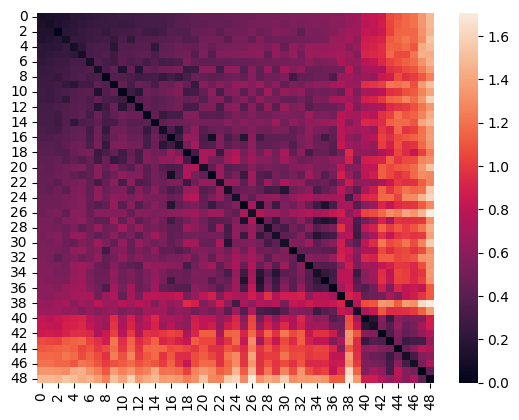

In [19]:
# Тест 2 (Визуализация матрицы; мера: calc_measure_money)

# Картина 'Portrait of Isaac Van der Beek' является самой дорогой картиной
# Из матрицы и распечатанных значений видно, что в левом верхнем углу сосредоточены дорогие портреты, 
# а в правом нижнем углу дешевые пейзажи, такие как 'Vegetable Garden, Overcast Morning, Éragny'
    
default_filter = Filter()
default_filter.width_min = 40
default_filter.width_max = 45
rec_system = RecomendationSystem()
rec_system.set_closeness_strategy(ClosenessStrategy.NearDistinctSeeds)
rec_system.calc_measure_function(calc_measure_money)
rec_system.visualize_matrix()

[('Portrait of Isaac Van der Beek', 0.7), ('Portrait of Jean Terford David', 0.711111111111111), ('Captain Charles Stewart', 0.7606031501455085), ('Portrait of Mada Primavesi', 0.7833333333333332), ('Vice-Admiral Edward Hughes', 0.7999999999999999), ('Portrait of Anne, Countess of Chesterfield', 0.8467142612566195), ('Portrait of Madame Gaudibert', 0.9839364834788418), ('Portrait of Tieleman Roosterman', 1.025238095238095), ('The Source', 1.1317142612566196), ('Woman Drying Her Foot', 1.190238095238095), ('Portrait of Beatrice Hastings', 1.2410700442759917), ('Portrait of David Montague, 2nd Baron Erskine', 1.268333333333333), ('Cupid Untying the Zone of Venus', 1.346111111111111), ('Portrait of General Antonio Ricardos', 1.3966666666666665), ('Mary Harvey, Mrs. Paul Beck Jr.', 1.4), ('Are You Jealous?', 1.4885445183642305), ('The Marquesa de la Solana', 1.5272698168121752), ('The Guitar Majo', 1.7), ('Doctor', 1.7039364834788417), ('A Girl Defending Herself Against Eros', 1.7339364834

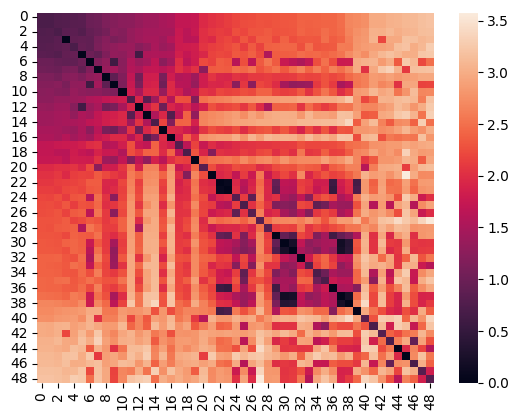

In [20]:
# Тест 3 (Визуализация матрицы; мера: calc_measure_main)

# Картина 'Portrait of Isaac Van der Beek' является первой в списке, поэтому все столбцы матрицы упорядочены
# по возрастанию расстояния до нее. Из выведенных значений опять видно, что портреты находятся в левом верхнем углу,
# а пейзежи в правом нижнем

# На значение расстояния в наибольшей степени влияет стиль, жанр и изображаемый объект  

default_filter = Filter()
default_filter.width_min = 40
default_filter.width_max = 45
rec_system = RecomendationSystem()
rec_system.set_closeness_strategy(ClosenessStrategy.NearDistinctSeeds)
rec_system.calc_measure_function(calc_measure_main)
rec_system.visualize_matrix()

In [31]:
# Тест 4 (Рекомендация: стратегия рекомендация первой)

rec_system = RecomendationSystem()
rec_system.set_closeness_strategy(ClosenessStrategy.NearDistinctSeeds)
rec_system.calc_measure_function(calc_measure_main)

width_filter = Filter()
width_filter.width_min = 40
width_filter.width_max = 45
items = rec_system.query_with_filter(width_filter, limit=1)
print("Seed item name = ", items[0].name)

default_filter = Filter()
give_recomendation_recomend_first_strategy(rec_system, likes=items, dislikes=[], filter=default_filter)

Seed item name =  Portrait of Beatrice Hastings


[DatasetItem(name='Portrait of Beatrice Hastings', full_name='Amedeo Modigliani', width=40, height=60, death=1920, sale_price=565, country='USA', style='Expressionism', subject='Portraits', genre='Portrait', medium='Oil on canvas', exhibition=True, for_sale=False, restored=True),
 DatasetItem(name='Woman Drying Her Foot', full_name='Edgar Degas', width=60, height=60, death=1917, sale_price=775, country='USA', style='Impressionism', subject='Nude', genre='Portrait', medium='Oil on canvas', exhibition=False, for_sale=False, restored=False),
 DatasetItem(name='The Source', full_name='Gustave Courbet', width=48, height=72, death=1877, sale_price=745, country='USA', style='Realism', subject='Nude', genre='Portrait', medium='Oil on canvas', exhibition=False, for_sale=True, restored=True),
 DatasetItem(name='Portrait of Mada Primavesi', full_name='Gustav Klimt', width=54, height=68, death=1918, sale_price=785, country='USA', style='Art Nouveau', subject='Portraits', genre='Historical characte

In [22]:
# Тест 5 (Рекомендация: стратегия фильтр первый)

# В случае, если сначала выполняется фильтрация, то будут выведен весь "ассортимент" картин. 
# При этом картины в данном случае будут упорядочены по близости к найденным картине
# Опять же портреты будут в топе

rec_system = RecomendationSystem()
rec_system.set_closeness_strategy(ClosenessStrategy.NearDistinctSeeds)
rec_system.calc_measure_function(calc_measure_main)

width_filter = Filter()
width_filter.width_min = 40
width_filter.width_max = 45
items = rec_system.query_with_filter(width_filter, limit=1)
print("Seed item name = ", items[0].name)

default_filter = Filter()
result = give_recomendation_filter_first_strategy(rec_system, likes=items, dislikes=[], filter=width_filter)
[item.name for item in result]

Seed item name =  Portrait of Beatrice Hastings


['Portrait of Beatrice Hastings',
 'Woman Drying Her Foot',
 'The Source',
 'Portrait of Mada Primavesi',
 'Captain Charles Stewart',
 'Portrait of Madame Gaudibert',
 'Portrait of Isaac Van der Beek',
 'Portrait of Jean Terford David',
 'Portrait of Tieleman Roosterman',
 'Portrait of Anne, Countess of Chesterfield',
 'Are You Jealous?',
 'Vice-Admiral Edward Hughes',
 'Cupid Untying the Zone of Venus',
 'Doctor',
 'A Girl Defending Herself Against Eros',
 'Portrait of David Montague, 2nd Baron Erskine',
 'The Guitar Majo',
 'Portrait of General Antonio Ricardos',
 'Mary Harvey, Mrs. Paul Beck Jr.',
 'The Marquesa de la Solana',
 'Le Givre',
 'La Tour Eiffel',
 'Japanese Footbridge, Giverny',
 'The Lute Player',
 'Se`vres Bridge',
 'Il Penseroso',
 'Twilight Venice (San Giorgio Maggiore at Dusk)',
 'The Seine at Vétheuil',
 'The Spanish Stairs, Rome',
 'Lake Squam and the Sandwich Mountains',
 'Sunny Autumn Day',
 'Spring Morning in the Heart of the City',
 'Ship Trapped in Pack Ice',

In [32]:
# Тест 6 (Рекомендация: стратегия фильтр первый, портреты не в топе)

# В случае, если сначала выполняется фильтрация, то будут выведен весь "ассортимент" картин. 
# При этом картины в данном случае будут упорядочены по близости к найденным картине
# Искомая картина: subject="Marine Art/Maritime", genre="Coast", medium="Drybrush")
# В топе у нас морские пейзежи, жаль нет Айвазовского

rec_system = RecomendationSystem()
rec_system.set_closeness_strategy(ClosenessStrategy.NearDistinctSeeds)
rec_system.calc_measure_function(calc_measure_main)

name_filter = Filter()
name_filter.name = 'Coastal Scene'
items = rec_system.query_with_filter(name_filter, limit=1)
print("Seed item name = ", items[0].name)

default_filter = Filter()
result = give_recomendation_filter_first_strategy(rec_system, likes=items, dislikes=[], filter=name_filter)
[item.name for item in result]

Seed item name =  Coastal Scene


['Coastal Scene',
 'View of Part of Owharre Harbour, Island of Huahine',
 'Ship Trapped in Pack Ice',
 'Becalmed in Chilean Waters',
 'A Dutch Man-Of-War and Various Vessels in a Breeze',
 'A Squally Day in a Dutch Estuary',
 'Lake Squam and the Sandwich Mountains',
 'The Seine at Vétheuil',
 'The Subsiding of the Waters of the Deluge',
 'Se`vres Bridge',
 'Le Givre',
 'Twilight Venice (San Giorgio Maggiore at Dusk)',
 'The Falls of St. Anthony',
 'Waterloo Bridge, Sunlight Effect',
 'Mary Harvey, Mrs. Paul Beck Jr.',
 'Sunny Autumn Day',
 'Rose Bushes Under the Trees',
 'Il Penseroso',
 'Vegetable Garden, Overcast Morning, Éragny',
 'The Marquesa de la Solana',
 'Spring Morning in the Heart of the City',
 'Woman Drying Her Foot',
 'The Spanish Stairs, Rome',
 'Are You Jealous?',
 'La Tour Eiffel',
 'A Girl Defending Herself Against Eros',
 'The Guitar Majo',
 'Doctor',
 'Japanese Footbridge, Giverny',
 'View of the Arch of Constantine with the Colosseum',
 'Cupid Untying the Zone of V

In [24]:
# Тест 7 (Рекомендация: посмотрим, как работают дизлайки с обычной мерой)

# Давайти сначала попробуем подобрать морские пейзажи, но дорогие
# Для этого найдем морской пейзаж и "задизлайкаем" дешевую картину
# Но к сожалению, в провалилось много картин, похожих на "Vegetable Garden, Overcast Morning, Éragny", но имеющих большую цену

# Давайте изменим меру. Возможно, в реальности стоит также сменить меру (изменить коэффициенты), 
# если пользователь больше обращает внимание только на определенные характеристики товара

rec_system = RecomendationSystem()
rec_system.set_closeness_strategy(ClosenessStrategy.NearDistinctSeeds)
rec_system.calc_measure_function(calc_measure_main)

name_filter = Filter()
name_filter.name = 'Coastal Scene'
likes = rec_system.query_with_filter(name_filter, limit=1)
print("Seed liked item name = ", likes[0].name)

sale_price_filter = Filter()
sale_price_filter.sale_price_max = 480
dislikes = rec_system.query_with_filter(sale_price_filter, limit=1)
print("Seed disliked item names = ", dislikes[0].name)

default_filter = Filter()
result = give_recomendation_filter_first_strategy(rec_system, likes=likes, dislikes=dislikes, filter=name_filter)
[item.name for item in result]

Seed liked item name =  Coastal Scene
Seed disliked item names =  Vegetable Garden, Overcast Morning, Éragny


['Coastal Scene',
 'View of Part of Owharre Harbour, Island of Huahine',
 'A Dutch Man-Of-War and Various Vessels in a Breeze',
 'A Squally Day in a Dutch Estuary',
 'Ship Trapped in Pack Ice',
 'Becalmed in Chilean Waters',
 'Lake Squam and the Sandwich Mountains',
 'The Falls of St. Anthony',
 'Mary Harvey, Mrs. Paul Beck Jr.',
 'Portrait of General Antonio Ricardos',
 'Cupid Untying the Zone of Venus',
 'View of the Arch of Constantine with the Colosseum',
 'Vice-Admiral Edward Hughes',
 'The Virgin and Child with Five Angels',
 'La Tour Eiffel',
 'The Seine at Vétheuil',
 'Are You Jealous?',
 'Lamentation Over Dead Christ',
 'Portrait of David Montague, 2nd Baron Erskine',
 'A Girl Defending Herself Against Eros',
 'Sunny Autumn Day',
 'The Lute Player',
 'The Guitar Majo',
 'Portrait of Isaac Van der Beek',
 'Portrait of Jean Terford David',
 'Portrait of Mada Primavesi',
 'Il Penseroso',
 'Se`vres Bridge',
 'The Source',
 'Captain Charles Stewart',
 'Portrait of Anne, Countess of

In [25]:
# Тест 8 (Рекомендация: посмотрим, как работают дизлайки с мерой на цену)

# Давайти сначала попробует подобрать морские пейзажи, но дорогие
# Для этого найдем морской пейзаж и "задизлайкаем" дешевую картину
# Провалилось много картин, похожих на "Vegetable Garden, Overcast Morning, Éragny", но имеющих большую цену

# Теперь в топе дорогие, а внизу дешевые картины. Ах, ну теперь в топе у нас стало больше не МОРСКИХ пейзажей. А все из-за коэффициентов

rec_system = RecomendationSystem()
rec_system.set_closeness_strategy(ClosenessStrategy.NearDistinctSeeds)
rec_system.calc_measure_function(calc_measure_money)

name_filter = Filter()
name_filter.name = 'Coastal Scene'
likes = rec_system.query_with_filter(name_filter, limit=1)
print("Seed liked item name = ", likes[0].name)

sale_price_filter = Filter()
sale_price_filter.sale_price_max = 480
dislikes = rec_system.query_with_filter(sale_price_filter, limit=1)
print("Seed disliked item names = ", dislikes[0].name)

default_filter = Filter()
result = give_recomendation_filter_first_strategy(rec_system, likes=likes, dislikes=dislikes, filter=name_filter)
[item.name for item in result]

Seed liked item name =  Coastal Scene
Seed disliked item names =  Vegetable Garden, Overcast Morning, Éragny


['Coastal Scene',
 'A Dutch Man-Of-War and Various Vessels in a Breeze',
 'A Squally Day in a Dutch Estuary',
 'Cupid Untying the Zone of Venus',
 'Vice-Admiral Edward Hughes',
 'The Virgin and Child with Five Angels',
 'View of Part of Owharre Harbour, Island of Huahine',
 'Portrait of General Antonio Ricardos',
 'Mary Harvey, Mrs. Paul Beck Jr.',
 'View of the Arch of Constantine with the Colosseum',
 'Lamentation Over Dead Christ',
 'The Lute Player',
 'Ship Trapped in Pack Ice',
 'Becalmed in Chilean Waters',
 'Portrait of Isaac Van der Beek',
 'Portrait of Jean Terford David',
 'The Guitar Majo',
 'Portrait of David Montague, 2nd Baron Erskine',
 'Sunny Autumn Day',
 'Portrait of Mada Primavesi',
 'A Girl Defending Herself Against Eros',
 'Rose Bushes Under the Trees',
 'La Tour Eiffel',
 'The Subsiding of the Waters of the Deluge',
 'Spring Morning in the Heart of the City',
 'The Spanish Stairs, Rome',
 'The Falls of St. Anthony',
 'Lake Squam and the Sandwich Mountains',
 'Cont

In [35]:
# Тест 9 (Рекомендация: нечеткая функция, оптимальные цены)

# Оптимальная цена - цена от 500 до 600 USD (OptimalPrice)

# Если задать give_recomendation_filter_first_strategy обычный фильтр, 
# то система будет рекомендовать все подряд (т.е. не будет работать)

rec_system = RecomendationSystem()
rec_system.set_closeness_strategy(ClosenessStrategy.NearDistinctSeeds)
rec_system.calc_measure_function(calc_measure_money)

sale_price_filter = Filter()
sale_price_filter.price_approx = PriceMeasure.OptimalPrice
likes = rec_system.query_with_filter(sale_price_filter, limit=5)
for i in range(5):
    print("Seed liked item name = {0}; price = {1}".format(likes[i].name, likes[i].sale_price))

default_filter = Filter()
result = give_recomendation_filter_first_strategy(rec_system, likes=likes, dislikes=[], filter=sale_price_filter)
[(item.name, item.sale_price) for item in result]

Seed liked item name = Still Life with a Skull and a Writing Quill; price = 585
Seed liked item name = Se`vres Bridge; price = 635
Seed liked item name = Portrait of Beatrice Hastings; price = 565
Seed liked item name = Japanese Footbridge, Giverny; price = 635
Seed liked item name = Le Givre; price = 565


[('Le Givre', 565),
 ('Waterloo Bridge, Sunlight Effect', 565),
 ('Se`vres Bridge', 635),
 ('Japanese Footbridge, Giverny', 635),
 ('The Magpie', 565),
 ('Portrait of Beatrice Hastings', 565),
 ('Still Life with a Skull and a Writing Quill', 585),
 ('Twilight Venice (San Giorgio Maggiore at Dusk)', 495),
 ('Portrait of Tieleman Roosterman', 655),
 ('The Seine at Vétheuil', 725),
 ('Vegetable Garden, Overcast Morning, Éragny', 455),
 ('Portrait of Madame Gaudibert', 725),
 ('Lake Squam and the Sandwich Mountains', 745),
 ('Doctor', 725),
 ('Il Penseroso', 745),
 ('Are You Jealous?', 725),
 ('Becalmed in Chilean Waters', 745),
 ('Ship Trapped in Pack Ice', 745),
 ('The Falls of St. Anthony', 745),
 ('Woman Drying Her Foot', 775),
 ('The Source', 745),
 ('Spring Morning in the Heart of the City', 785),
 ('Captain Charles Stewart', 745),
 ('Portrait of Anne, Countess of Chesterfield', 745),
 ('The Spanish Stairs, Rome', 785),
 ('View of Part of Owharre Harbour, Island of Huahine', 745),
 (

In [36]:
# Тест 10 (Рекомендация: нечеткая функция, очень высокие цены)

# Очень высокая цена - цена более 700 USD (VeryHighPrice)

# Если задать give_recomendation_filter_first_strategy обычный фильтр, 
# то система будет рекомендовать все подряд (т.е. не будет работать)

rec_system = RecomendationSystem()
rec_system.set_closeness_strategy(ClosenessStrategy.NearDistinctSeeds)
rec_system.calc_measure_function(calc_measure_money)

sale_price_filter = Filter()
sale_price_filter.price_approx = PriceMeasure.VeryHighPrice
likes = rec_system.query_with_filter(sale_price_filter, limit=5)
print("Seed liked item name = {0}; price = {1}".format(likes[0].name, likes[0].sale_price))

default_filter = Filter()
result = give_recomendation_filter_first_strategy(rec_system, likes=likes, dislikes=[], filter=sale_price_filter)
[(item.name, item.sale_price) for item in result]

Seed liked item name = Portrait of Isaac Van der Beek; price = 785


[('Portrait of Jean Terford David', 785),
 ('Portrait of Mada Primavesi', 785),
 ('Portrait of Isaac Van der Beek', 785),
 ('Woman Drying Her Foot', 775),
 ('Vice-Admiral Edward Hughes', 785),
 ('The Guitar Majo', 785),
 ('Sunny Autumn Day', 785),
 ('Portrait of David Montague, 2nd Baron Erskine', 785),
 ('Cupid Untying the Zone of Venus', 785),
 ('The Spanish Stairs, Rome', 785),
 ('La Tour Eiffel', 785),
 ('Mary Harvey, Mrs. Paul Beck Jr.', 785),
 ('Portrait of General Antonio Ricardos', 785),
 ('Spring Morning in the Heart of the City', 785),
 ('A Girl Defending Herself Against Eros', 795),
 ('A Squally Day in a Dutch Estuary', 785),
 ('The Subsiding of the Waters of the Deluge', 785),
 ('View of the Arch of Constantine with the Colosseum', 795),
 ('A Dutch Man-Of-War and Various Vessels in a Breeze', 785),
 ('Coastal Scene', 785),
 ('The Source', 745),
 ('Captain Charles Stewart', 745),
 ('Portrait of Anne, Countess of Chesterfield', 745),
 ('The Lute Player', 825),
 ('Il Penseroso

In [28]:
# Тест 11 (Рекомендация: стратегия рекомендация первой)

# В случае, если сначала выполняется рекомендация, то в конечную выборку могут войти
# только записи, удовлетворяющие фильтру

rec_system = RecomendationSystem()
rec_system.set_closeness_strategy(ClosenessStrategy.NearDistinctSeeds)
rec_system.calc_measure_function(calc_measure_main)

width_filter = Filter()
width_filter.width_min = 40
width_filter.width_max = 45
items = rec_system.query_with_filter(width_filter, limit=1)
print("Seed item name = ", items[0].name)

default_filter = Filter()
result = give_recomendation_recomend_first_strategy(rec_system, likes=items, dislikes=[], filter=width_filter)
[item.name for item in result]

Seed item name =  Portrait of Beatrice Hastings


['Portrait of Beatrice Hastings']

In [29]:
# Тест 12 (Рекомендация: стратегия рекомендация первой, портреты в середине)

# Установка дефолтного фильтра и поиск картин, похожих на данную (Il Penseroso: style=American Landscape, subject=Landscape Art, genre=Landscape, medium=Oil on canvas)

rec_system = RecomendationSystem()
rec_system.set_closeness_strategy(ClosenessStrategy.NearDistinctSeeds)
rec_system.calc_measure_function(calc_measure_main)

name_filter = Filter()
name_filter.name = 'Il Penseroso'
likes = rec_system.query_with_filter(name_filter, limit=1)
print("Seed liked item name = ", likes[0].name)

default_filter = Filter()
result = give_recomendation_recomend_first_strategy(rec_system, likes=likes, dislikes=[], filter=default_filter)
[item.name for item in result]

Seed liked item name =  Il Penseroso


['Il Penseroso',
 'Sunny Autumn Day',
 'The Falls of St. Anthony',
 'The Subsiding of the Waters of the Deluge',
 'Lake Squam and the Sandwich Mountains',
 'Ship Trapped in Pack Ice',
 'The Seine at Vétheuil',
 'Se`vres Bridge',
 'Becalmed in Chilean Waters',
 'Le Givre',
 'A Squally Day in a Dutch Estuary',
 'The Source',
 'The Guitar Majo',
 'View of the Arch of Constantine with the Colosseum',
 'Spring Morning in the Heart of the City',
 'Woman Drying Her Foot',
 'Twilight Venice (San Giorgio Maggiore at Dusk)',
 'Doctor',
 'La Tour Eiffel',
 'The Spanish Stairs, Rome',
 'Japanese Footbridge, Giverny',
 'The Lute Player',
 'Captain Charles Stewart',
 'Are You Jealous?',
 'Portrait of Isaac Van der Beek',
 'Portrait of Jean Terford David',
 'Portrait of Beatrice Hastings',
 'Containers, Fruit, Dishcloth',
 'Portrait of Anne, Countess of Chesterfield',
 'Portrait of Mada Primavesi',
 'Cupid Untying the Zone of Venus',
 'Vice-Admiral Edward Hughes',
 'Portrait of Madame Gaudibert',
 'P

In [30]:
# Тест 13 (Рекомендация: стратегия рекомендация первой, портреты внизу)

# Установка дефолтного фильтра и поиск картин, похожих на данную (Il Penseroso: style=American Landscape, subject=Landscape Art, genre=Landscape, medium=Oil on canvas)

rec_system = RecomendationSystem()
rec_system.set_closeness_strategy(ClosenessStrategy.NearDistinctSeeds)
rec_system.calc_measure_function(calc_measure_main)

name_filter = Filter()
name_filter.name = 'Il Penseroso'
likes = rec_system.query_with_filter(name_filter, limit=1)
print("Seed liked item name = ", likes[0].name)

name_filter = Filter()
name_filter.name = 'Portrait of Isaac Van der Beek'
dislikes = rec_system.query_with_filter(name_filter, limit=1)
print("Seed disliked item name = ", dislikes[0].name)

default_filter = Filter()
result = give_recomendation_recomend_first_strategy(rec_system, likes=likes, dislikes=dislikes, filter=default_filter)
[item.name for item in result]

Seed liked item name =  Il Penseroso
Seed disliked item name =  Portrait of Isaac Van der Beek


['Il Penseroso',
 'Sunny Autumn Day',
 'The Subsiding of the Waters of the Deluge',
 'The Falls of St. Anthony',
 'Lake Squam and the Sandwich Mountains',
 'The Seine at Vétheuil',
 'Le Givre',
 'Twilight Venice (San Giorgio Maggiore at Dusk)',
 'Se`vres Bridge',
 'View of Part of Owharre Harbour, Island of Huahine',
 'Becalmed in Chilean Waters',
 'Ship Trapped in Pack Ice',
 'Vegetable Garden, Overcast Morning, Éragny',
 'A Squally Day in a Dutch Estuary',
 'A Dutch Man-Of-War and Various Vessels in a Breeze',
 'Coastal Scene',
 'The Magpie',
 'Waterloo Bridge, Sunlight Effect',
 'Japanese Footbridge, Giverny',
 'View of the Arch of Constantine with the Colosseum',
 'Spring Morning in the Heart of the City',
 'Still Life with a Skull and a Writing Quill',
 'Containers, Fruit, Dishcloth',
 'The Spanish Stairs, Rome',
 'Rose Bushes Under the Trees',
 'La Tour Eiffel',
 'Lamentation Over Dead Christ',
 'The Lute Player',
 'The Virgin and Child with Five Angels',
 'The Guitar Majo',
 'Do